# Fine-tuning lightgbm

This notebook is a continuation of the *main.ipynb*, where I will specifically fine-tune the xgboost model to the problem described in that notebook.

## Data

Let's import the data and split it in train and test set using the same configuration as used in the *main.ipynb*.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split


X = pd.read_csv('processed_public.csv', low_memory=False).dropna(subset='espera')
y = X['espera']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y,
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(f"{y_train.mean():.4f}", f"{y_test.mean():.4f}")

(169343, 122) (169343,)
(42336, 122) (42336,)
0.0174 0.0174


## Features

Let's use the same transformers for feature engineering as defined in *main.ipynb*.

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class TimeInformation(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        time_data = pd.to_datetime(X['hora_ref'])
        b = [0, 4, 8, 12, 16, 20, 24]
        l = ['late night', 'early morning', 'morning', 'noon', 'evening', 'night']
        X['period_day'] = pd.cut(time_data.dt.hour, bins=b, labels=l, include_lowest=True)
        X['day_of_week'] =  pd.Categorical(time_data.dt.day_of_week)
        return X

class CabeceiraTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['prev_troca_cabeceira'] = X['prev_troca_cabeceira'].astype(bool)
        X['troca_cabeceira_hora_anterior'] = X['troca_cabeceira_hora_anterior'].astype(bool)
        return X


class CombineMetarTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features=None, num_features=None):
        self.cat_features = cat_features
        self.num_features = num_features
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        for feature in self.cat_features:
            X[feature] = X[f'{feature}_metar'].fillna(X[f'{feature}_metaf'])
            # X.drop(columns=[f'{feature}_metar', f'{feature}_metaf'], inplace=True)
        for feature in self.num_features:
            X[feature] = X[[f'{feature}_metar', f'{feature}_metaf']].mean(axis=1)
            # X.drop(columns=[f'{feature}_metar', f'{feature}_metaf'], inplace=True)
        return X

class RouteTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['route'] = X['origem'] + '-' + X['destino']
        return X

# # TODO implement origem destino in this one
# class WindDirectionTransformer(TransformerMixin, BaseEstimator):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X, y=None):
#         X['wind_direction_vrb_origem'] = False
#         wind_direction_vrb = (X['wind_direction_origem_mean'].isna()) & (X['metar'].str.contains('VRB'))
#         X.loc[wind_direction_vrb, 'wind_direction_vrb'] = True
#         return X


class WeatherTransformer(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['current_wx_origem'] = X['current_wx1_origem'].fillna('') + X['current_wx2_origem'].fillna('') + X['current_wx3_origem'].fillna('')
        X['current_wx_destino'] = X['current_wx1_destino'].fillna('') + X['current_wx2_destino'].fillna('') + X['current_wx3_destino'].fillna('')

        intensity_cat = ['VC', '-', '', '+']
        descriptor_cat = ['MI', 'PR', 'BC', 'DR', 'BL', 'SH', 'TS', 'FZ']
        descriptor_cat = [i+d for i in intensity_cat for d in descriptor_cat]
        precipitation_cat = ['DZ', 'RA', 'SN', 'SG', 'IC', 'PL', 'GR', 'GS', 'UP']
        precipitation_cat = [i+d for i in intensity_cat for d in precipitation_cat]
        obscuration_cat = ['BR', 'FG', 'FU', 'VA', 'DU', 'SA', 'HZ', 'PY']
        obscuration_cat = [i+d for i in intensity_cat for d in obscuration_cat]
        other_cat = ['PO', 'SQ', 'FC', 'SS', 'DS']
        other_cat = [i+d for i in intensity_cat for d in other_cat]
        weather_categories = descriptor_cat + precipitation_cat + obscuration_cat + other_cat

        X['current_wx_origem'] = pd.Categorical(X['current_wx_origem'], categories=weather_categories)
        X['current_wx_destino'] = pd.Categorical(X['current_wx_destino'], categories=weather_categories)
        
        # X.drop(columns=[f'current_wx{i}_{source}' for i in range(1,4) for source in ['origem', 'destino']], inplace=True)
        return X

In [3]:
from sklearn.pipeline import Pipeline
pd.options.mode.chained_assignment = None

metar_num_features = ['wind_direction', 
                      'wind_speed', 
                      'wind_gust', 
                      'visibility', 
                      'low_cloud_level', 
                      'medium_cloud_level', 
                      'high_cloud_level', 
                      'highest_cloud_level', 
                      'cloud_coverage', 
                      'air_temperature', 
                      'dew_point_temperature',
                      'altimeter',
                      'elevation',
                     ]
metar_num_features = [f+'_origem' for f in metar_num_features] + [f+'_destino' for f in metar_num_features]

metar_cat_features = ['low_cloud_type', 
                      'medium_cloud_type', 
                      'high_cloud_type', 
                      'highest_cloud_type', 
                      'current_wx1',
                      'current_wx2',
                      'current_wx3',
                     ]
metar_cat_features = [f+'_origem' for f in metar_cat_features] + [f+'_destino' for f in metar_cat_features]

create_features_pipeline = Pipeline([
    ('route', RouteTransformer()),
    ('cabeceira', CabeceiraTransformer()),
    ('time', TimeInformation()),
    ('combine_metar', CombineMetarTransformer(
        cat_features=metar_cat_features,
        num_features=metar_num_features,
    )),
    # ('wind_vrb', WindDirectionTransformer()),
    ('weather', WeatherTransformer()),
])

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer

num_median_features = ['wind_direction', 'wind_speed', 'visibility', 'cloud_coverage', 'air_temperature', 'dew_point_temperature', 'altimeter', 'elevation']
num_median_features = [f+'_origem' for f in num_median_features] + [f+'_destino' for f in num_median_features]
num_median_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
])

num_zero_features = ['wind_gust']
num_zero_features = [f+'_origem' for f in num_zero_features] + [f+'_destino' for f in num_zero_features]
num_zero_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler()),
])

# bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior', 'wind_direction_vrb']
bin_features = ['prev_troca_cabeceira', 'troca_cabeceira_hora_anterior']
# bin_features = [f+'_origem' for f in bin_features] + [f+'_destino' for f in bin_features]
bin_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median', add_indicator=True)),
    ('scaler', StandardScaler()),
])

cat_features = ['origem', 'destino', 'route', 'period_day', 'day_of_week']
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', add_indicator=True)),
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

weather_features = ['current_wx']
weather_features = [f+'_origem' for f in weather_features] + [f+'_destino' for f in weather_features]
weather_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

clouds_num_features = ['low_cloud_level', 'medium_cloud_level', 'high_cloud_level', 'highest_cloud_level']
clouds_num_features = [f+'_origem' for f in clouds_num_features] + [f+'_destino' for f in clouds_num_features]
clouds_num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=10000, add_indicator=True)),
    ('scaler', StandardScaler()),
])

clouds_cat_features = ['low_cloud_type', 'medium_cloud_type', 'high_cloud_type', 'highest_cloud_type']
clouds_cat_features = [f+'_origem' for f in clouds_cat_features] + [f+'_destino' for f in clouds_cat_features]
clouds_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='SKC')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

data_pipeline = ColumnTransformer([
    ('num_median', num_median_pipeline, num_median_features),
    ('num_zero', num_zero_pipeline, num_zero_features),
    ('binary', bin_pipeline, bin_features),
    ('cat', cat_pipeline, cat_features),
    ('weather', weather_pipeline, weather_features),
    ('clouds_num', clouds_num_pipeline, clouds_num_features),
    ('clouds_cat', clouds_cat_pipeline, clouds_cat_features),
])

## Model

I'll be using the XGBoost model for this one, with adversarial sampling as described in *adversarial.ipynb*.

In [5]:
sample_weight = pd.read_csv('sample_weight_4.csv', index_col=0).loc[X_train.index, '0'].values
print(len(sample_weight))

169343


### Feature importance

Let's have a look at the feature importances of the base XGBoost model. This might give us some insight about the features engineered before.

In [6]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('selector', VarianceThreshold()),
    ('model', LGBMClassifier(verbose=-1)),
])

clf.fit(X_train, y_train, model__sample_weight=sample_weight)

Pipeline(steps=[('features',
                 Pipeline(steps=[('route', RouteTransformer()),
                                 ('cabeceira', CabeceiraTransformer()),
                                 ('time', TimeInformation()),
                                 ('combine_metar',
                                  CombineMetarTransformer(cat_features=['low_cloud_type_origem',
                                                                        'medium_cloud_type_origem',
                                                                        'high_cloud_type_origem',
                                                                        'highest_cloud_type_origem',
                                                                        'current_wx1_origem',
                                                                        'current_wx2_origem',
                                                                        'current_wx3...
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['low_cloud_type_origem',
                                                   'medium_cloud_type_origem',
                                                   'high_cloud_type_origem',
                                                   'highest_cloud_type_origem',
                                                   'low_cloud_type_destino',
                                                   'medium_cloud_type_destino',
                                                   'high_cloud_type_destino',
                                                   'highest_cloud_type_destino'])])),
                ('selector', VarianceThreshold()),
                ('model', LGBMClassifier(verbose=-1))])

Number of features: 289


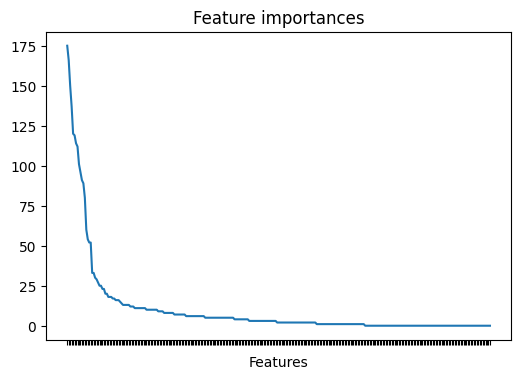

In [7]:
import matplotlib.pyplot as plt

features = [f.split('__')[-1] for f in clf.named_steps['data'].get_feature_names_out()]

print(f'Number of features: {len(features)}')
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(1, figsize=(6,4))
ax.set_xticklabels([])
ax.plot(feature_importance)
ax.set_title('Feature importances')
ax.set_xlabel('Features')
plt.show()

In [8]:
print('Most important features')
print(feature_importance.head(20))

Most important features
wind_direction_destino           175
altimeter_destino                166
air_temperature_destino          150
wind_speed_destino               137
air_temperature_origem           120
wind_direction_origem            119
wind_speed_origem                114
low_cloud_level_destino          112
altimeter_origem                 101
dew_point_temperature_destino     96
dew_point_temperature_origem      91
low_cloud_level_origem            89
visibility_destino                80
medium_cloud_level_destino        60
elevation_destino                 54
cloud_coverage_destino            52
medium_cloud_level_origem         52
visibility_origem                 33
elevation_origem                  33
cloud_coverage_origem             30
dtype: int32


We see that the most important features are related to the weather information, both at destination as well as departure.

In [9]:
unimportant_features = feature_importance[feature_importance == 0]
print(f'Number of unimportant features: {len(unimportant_features)}')
print(*(f for f in set([f.replace(f.split('_')[-1], '')[:-1] for f in unimportant_features.index])), sep='\n')

Number of unimportant features: 86
high_cloud_type_origem
route
missingindicator_visibility
highest_cloud_type_destino
highest_cloud_level
missingindicator_low_cloud_level
medium_cloud_type_destino
missingindicator_air_temperature
highest_cloud_type_origem
low_cloud_type_destino
missingindicator_dew_point_temperature
high_cloud_type_destino
missingindicator_elevation
medium_cloud_type_origem
current_wx_destino
low_cloud_type_origem
missingindicator_cloud_coverage
missingindicator_altimeter
current_wx_origem


Out of the 289 features initially selected, 86 are unimportant for the model.

We could explore some feature engineering by iteratively selecting features using the feature importance. This won't be done for now and is left as a future exploration.

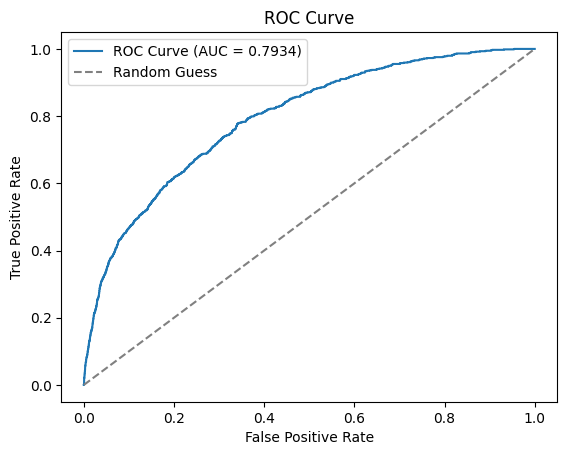

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_proba = clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, pred_proba)
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc)

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray', label = 'Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Grid search

I now proceed to do some fine-tuning on the base model.

We will explore a few parameters, namely:
- *n_estimators*:
- *scale_pos_weight*:
- *max_depth* and *min_child_weight*:
- *gamma*:
- *subsample* and *colsample_bytree*:
- *max_delta_step*:
- *reg_alpha*:

The goal is to use grid search cross validation to find the best parameters using ROC AUC as a metric over the validation set.

In [12]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier

def my_grid_search(param_clf, param_grid):
    clf = Pipeline([
        ('features', create_features_pipeline),
        ('data', data_pipeline),
        ('selector', VarianceThreshold()),
        ('model', LGBMClassifier(verbose=-1, **param_clf))
    ])

    cv = StratifiedKFold(n_splits=5)
    gsearch = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv, refit=False)
    start = time.time()
    gsearch.fit(X_train, y_train, model__sample_weight=sample_weight)
    print(f'time = {round(time.time()-start, 2)}s')
    print(gsearch.best_params_, gsearch.best_score_)

In [14]:
param_grid = {
    'model__num_leaves': [10, 100], # default 31
}

param_clf = {
    'learning_rate': 0.1,
}

my_grid_search(param_clf, param_grid)

time = 25.45s
{'model__num_leaves': 100} 0.7966223957079424


In [15]:
param_grid = {
    'model__num_leaves': [50, 75, 125, 150], # default 31
}

param_clf = {
    'learning_rate': 0.1,
}

my_grid_search(param_clf, param_grid)

time = 68.72s
{'model__num_leaves': 150} 0.7983394012345404


In [16]:
param_grid = {
    'model__num_leaves': [200, 300, 400], # default 31
}

param_clf = {
    'learning_rate': 0.1,
}

my_grid_search(param_clf, param_grid)

time = 60.75s
{'model__num_leaves': 300} 0.800100343904991


In [17]:
param_grid = {
    'model__min_data_in_leaf': [100, 1000], # default 20
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
}

my_grid_search(param_clf, param_grid)

time = 39.71s
{'model__min_data_in_leaf': 100} 0.8017655814634894


In [18]:
param_grid = {
    'model__min_data_in_leaf': [10, 70, 200], # default 20
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
}

my_grid_search(param_clf, param_grid)

time = 63.95s
{'model__min_data_in_leaf': 70} 0.800827860313645


Best performance is min_data_in_leaf =  100

In [19]:
param_grid = {
    'model__max_depth': [1, 3, 5, 10], # default -1 (no limit)
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
}

my_grid_search(param_clf, param_grid)

time = 48.55s
{'model__max_depth': 10} 0.7966730153109102


Let's keep the default of -1 (no limit), score = 0.8017655814634894

In [20]:
param_grid = {
    'model__pos_bagging_fraction': [0.1, 0.5, 0.9], # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
}

my_grid_search(param_clf, param_grid)

time = 62.96s
{'model__pos_bagging_fraction': 0.1} 0.8017657036966277


In [21]:
param_grid = {
    'model__scale_pos_weight': [0.5, 10, 50, 100], # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
}

my_grid_search(param_clf, param_grid)

time = 90.76s
{'model__scale_pos_weight': 0.5} 0.8009271537333212


In [22]:
param_grid = {
    'model__scale_pos_weight': [0.1, 0.3, 0.7, 0.9], # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
}

my_grid_search(param_clf, param_grid)

time = 84.82s
{'model__scale_pos_weight': 0.3} 0.8021679198884406


In [24]:
param_grid = {
    'model__min_gain_to_split': [1e-3, 1e-1], # default 0.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
}

my_grid_search(param_clf, param_grid)

time = 33.4s
{'model__min_gain_to_split': 0.001} 0.7983456944721434


min_gain_to_split improves training time but reduces performance. I'll keep the default value of 0.0 to ensure best performance. Score = 0.8021679198884406

In [25]:
param_grid = {
    'model__max_bin': [10, 100, 1000], # default 255
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
}

my_grid_search(param_clf, param_grid)

time = 111.01s
{'model__max_bin': 1000} 0.8007571473105226


In [26]:
param_grid = {
    'model__max_bin': [200, 300, 700], # default 255
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
}

my_grid_search(param_clf, param_grid)

time = 65.93s
{'model__max_bin': 200} 0.8023438648917285


In [27]:
param_grid = {
    'model__min_sum_hessian_in_leaf': [1e-5, 1e-1, 1], # default 1e-3
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
}

my_grid_search(param_clf, param_grid)

time = 62.66s
{'model__min_sum_hessian_in_leaf': 1e-05} 0.8034346265060768


In [28]:
param_grid = {
    'model__min_sum_hessian_in_leaf': [1e-7, 1e-6, 1e-4], # default 1e-3
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
}

my_grid_search(param_clf, param_grid)

time = 61.22s
{'model__min_sum_hessian_in_leaf': 0.0001} 0.8034858437300583


In [29]:
param_grid = {
    'model__bagging_freq': [2, 5, 10], # default 0
    'model__bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9] # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
    'min_sum_hessian_in_leaf': 1e-4,
}

my_grid_search(param_clf, param_grid)

time = 310.63s
{'model__bagging_fraction': 0.9, 'model__bagging_freq': 10} 0.7923684407776935


Worst performance than the default values.

In [30]:
param_grid = {
    'model__feature_fraction': [0.1, 0.3, 0.5, 0.7, 0.9], # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
    'min_sum_hessian_in_leaf': 1e-4,
    'bagging_freq': 0,
    'bagging_fraction': 1.0,
}

my_grid_search(param_clf, param_grid)

time = 105.32s
{'model__feature_fraction': 0.5} 0.805816472629342


In [31]:
param_grid = {
    'model__feature_fraction': [0.4, 0.6], # default 1.0
}

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
    'min_sum_hessian_in_leaf': 1e-4,
    'bagging_freq': 0,
    'bagging_fraction': 1.0,
}

my_grid_search(param_clf, param_grid)

time = 43.59s
{'model__feature_fraction': 0.4} 0.8039292370788971


### Final model

We now have the hypeparameters of the final model, which has a AUC score of 0.8078, an improvement of 1.8% over the base model at *main.ipynb* of 0.7934.

In [32]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.feature_selection import VarianceThreshold

param_clf = {
    'learning_rate': 0.1,
    'num_leaves': 300,
    'min_data_in_leaf': 100,
    'scale_pos_weight': 0.3,
    'max_bin': 200,
    'min_sum_hessian_in_leaf': 1e-4,
    'bagging_freq': 0,
    'bagging_fraction': 1.0,
    'feature_fraction': 0.5,
}

clf = Pipeline([
    ('features', create_features_pipeline),
    ('data', data_pipeline),
    ('selector', VarianceThreshold()),
    ('model', LGBMClassifier(verbose=-1, **param_clf))
])

clf.fit(X_train, y_train, model__sample_weight=sample_weight)

Pipeline(steps=[('features',
                 Pipeline(steps=[('route', RouteTransformer()),
                                 ('cabeceira', CabeceiraTransformer()),
                                 ('time', TimeInformation()),
                                 ('combine_metar',
                                  CombineMetarTransformer(cat_features=['low_cloud_type_origem',
                                                                        'medium_cloud_type_origem',
                                                                        'high_cloud_type_origem',
                                                                        'highest_cloud_type_origem',
                                                                        'current_wx1_origem',
                                                                        'current_wx2_origem',
                                                                        'current_wx3...
                                                   'highest_cloud_type_origem',
                                                   'low_cloud_type_destino',
                                                   'medium_cloud_type_destino',
                                                   'high_cloud_type_destino',
                                                   'highest_cloud_type_destino'])])),
                ('selector', VarianceThreshold()),
                ('model',
                 LGBMClassifier(bagging_fraction=1.0, bagging_freq=0,
                                feature_fraction=0.5, max_bin=200,
                                min_data_in_leaf=100,
                                min_sum_hessian_in_leaf=0.0001, num_leaves=300,
                                scale_pos_weight=0.3, verbose=-1))])

Number of features: 289


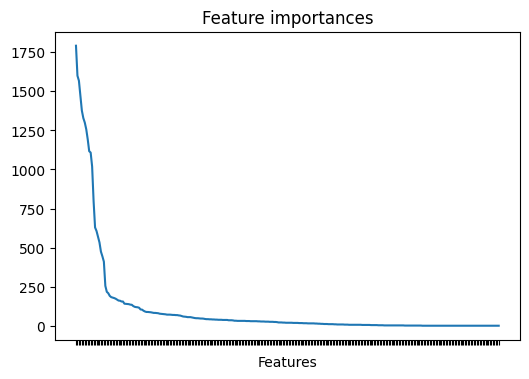

In [33]:
import matplotlib.pyplot as plt

features = [f.split('__')[-1] for f in clf.named_steps['data'].get_feature_names_out()]

print(f'Number of features: {len(features)}')
feature_importance = pd.Series(clf.named_steps['model'].feature_importances_, index=features).sort_values(ascending=False)

fig, ax = plt.subplots(1, figsize=(6,4))
ax.set_xticklabels([])
ax.plot(feature_importance)
ax.set_title('Feature importances')
ax.set_xlabel('Features')
plt.show()

In [34]:
print('Most important features')
print(feature_importance.head(20))

Most important features
wind_direction_origem            1792
low_cloud_level_destino          1600
wind_direction_destino           1568
dew_point_temperature_destino    1476
air_temperature_origem           1377
air_temperature_destino          1329
altimeter_origem                 1300
wind_speed_origem                1257
wind_speed_destino               1193
low_cloud_level_origem           1117
altimeter_destino                1108
dew_point_temperature_origem     1019
visibility_destino                797
cloud_coverage_destino            629
medium_cloud_level_origem         606
medium_cloud_level_destino        570
elevation_origem                  533
cloud_coverage_origem             474
elevation_destino                 444
visibility_origem                 410
dtype: int32


The final model puts even more importance on some features such as wind, temperature and cloud information, both at departure but also at arrival.

In [35]:
unimportant_features = feature_importance[feature_importance == 0]
print(f'Number of unimportant features: {len(unimportant_features)}')
print(*(f for f in set([f.replace(f.split('_')[-1], '')[:-1] for f in unimportant_features.index])), sep='\n')

Number of unimportant features: 53
highest_cloud_type_destino
highest_cloud_type_origem
route
low_cloud_type_origem
current_wx_destino
current_wx_origem


Out of the 289 features initially selected, only 53 are now unimportant for the model.

As discussed, we could now explore some feature engineering by iteratively selecting features using the feature importance. This won't be done for now and is left as a future exploration.

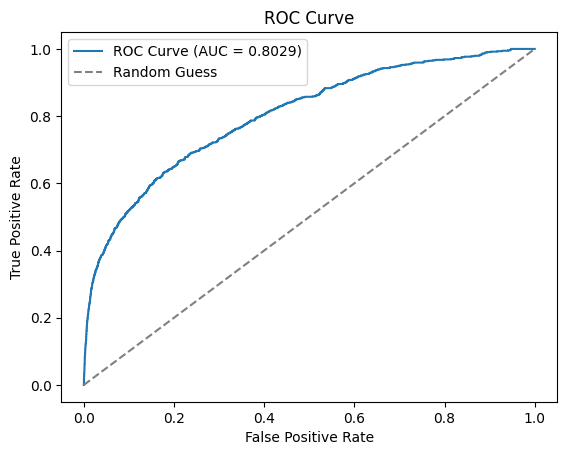

In [36]:
from sklearn.metrics import roc_curve, roc_auc_score

pred_proba = clf.predict_proba(X_test)[:,1]

auc = roc_auc_score(y_test, pred_proba)
fpr, tpr, _ = roc_curve(y_test, pred_proba)
plt.plot(fpr, tpr, label = 'ROC Curve (AUC = %0.4f)' % auc)

plt.plot([0,1], [0,1], linestyle = '--', color = 'gray', label = 'Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

The final model obtains a ROC AUC score of 0.8029 on the test set, separated at the beginning of the training and never seen by it.

## Probability calibration

Before submitting the predictions, let's have a look at the f1-score for different thresholds.

In [37]:
from sklearn.metrics import f1_score

for th in range(1, 11, 1):
    th /= 10
    y_pred = (pred_proba > th).astype(int)
    print(f'{th}: {f1_score(y_test, y_pred)}')

0.1: 0.23648648648648649
0.2: 0.18092428711897737
0.3: 0.14847161572052403
0.4: 0.12895927601809956
0.5: 0.11072664359861592
0.6: 0.10141509433962265
0.7: 0.0847457627118644
0.8: 0.062266500622665005
0.9: 0.03636363636363636
1.0: 0.0


In [38]:
from sklearn.metrics import f1_score

for th in range(1, 20, 1):
    th /= 100
    y_pred = (pred_proba > th).astype(int)
    print(f'{th}: {f1_score(y_test, y_pred)}')

0.01: 0.189960925758942
0.02: 0.23920265780730898
0.03: 0.2570605187319885
0.04: 0.2514657980456026
0.05: 0.24714285714285714
0.06: 0.24492862509391436
0.07: 0.24461538461538462
0.08: 0.2414614773629865
0.09: 0.2369281045751634
0.1: 0.23648648648648649
0.11: 0.22817631806395852
0.12: 0.2226148409893993
0.13: 0.2148014440433213
0.14: 0.2056932966023875
0.15: 0.20446096654275092
0.16: 0.19452313503305005
0.17: 0.1954459203036053
0.18: 0.18689788053949905
0.19: 0.1828793774319066


The best f1-score for the test data indeed happens for a threshold at 0.03. So let's use this information to predict the submission data.

In [39]:
from joblib import dump
dump(clf, 'lgbm_th003_auc_08029.joblib')

['lgbm_th003_auc_08029.joblib']